In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from PIL import Image
from os import listdir
import csv
import random
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import random

import numpy as np
from scipy import misc
from PIL import Image
import glob
import imageio
import os

import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from google.colab import files

In [ ]:
from google.colab import drive #load data from your google drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
class SegNet(nn.Module):
    """neural network architecture inspired by SegNet"""

    def __init__(self):
        super(SegNet, self).__init__()
        
        #Encoder
        self.conv1 = nn.Conv2d(3, 64, (3,3), padding=1)
        self.conv2 = nn.Conv2d(64, 64, (3,3), padding=1)
        self.enc1_bn = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(64, 128, (3,3), padding=1)
        self.conv4 = nn.Conv2d(128, 128, (3,3), padding=1)
        self.enc2_bn = nn.BatchNorm2d(128)
        self.maxpool2 = nn.MaxPool2d((2,2),2)

        self.conv5 = nn.Conv2d(128, 256, (3,3), padding=1)
        self.conv6 = nn.Conv2d(256, 256, (3,3), padding=1)
        self.conv7 = nn.Conv2d(256, 256, (3,3), padding=1)
        self.enc3_bn = nn.BatchNorm2d(256)
        self.maxpool3 = nn.MaxPool2d((2,2),2)

        self.conv8 = nn.Conv2d(256, 512, (3,3), padding=1)
        self.conv9 = nn.Conv2d(512, 512, (3,3), padding=1)
        self.conv10 = nn.Conv2d(512, 512, (3,3), padding=1)
        self.enc4_bn = nn.BatchNorm2d(512)
        self.maxpool4 = nn.MaxPool2d((2,2),2)

        self.conv11 = nn.Conv2d(512, 512, (3,3), padding=1)
        self.conv12 = nn.Conv2d(512, 512, (3,3), padding=1)
        self.conv13 = nn.Conv2d(512, 512, (3,3), padding=1)
        self.enc5_bn = nn.BatchNorm2d(512)
        self.maxpool5 = nn.MaxPool2d((2,2),2)

        #Decoder
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.conv14 = nn.Conv2d(512,512, (3,3), padding=1)
        self.conv15 = nn.Conv2d(512,512, (3,3), padding=1)
        self.conv16 = nn.Conv2d(512,512, (3,3), padding=1)
        self.dec1_bn = nn.BatchNorm2d(512)

        self.upsample2 = nn.Upsample(scale_factor=2)
        self.conv17 = nn.Conv2d(512,512, (3,3), padding=1)
        self.conv18 = nn.Conv2d(512,512, (3,3), padding=1)
        self.conv19 = nn.Conv2d(512,256, (3,3), padding=1)
        self.dec2_bn = nn.BatchNorm2d(256)

        self.upsample3 = nn.Upsample(scale_factor=2)
        self.conv20 = nn.Conv2d(256,256, (3,3), padding=1)
        self.conv21 = nn.Conv2d(256,256, (3,3), padding=1)
        self.conv22 = nn.Conv2d(256,128, (3,3), padding=1)
        self.dec3_bn = nn.BatchNorm2d(128)

        self.upsample4 = nn.Upsample(scale_factor=2)
        self.conv23 = nn.Conv2d(128,128, (3,3), padding=1)
        self.conv24 = nn.Conv2d(128,64, (3,3), padding=1)
        self.dec4_bn = nn.BatchNorm2d(64)

        self.upsample5 = nn.Upsample(scale_factor=2)
        self.conv25 = nn.Conv2d(64,64, (3,3), padding=1)
        self.conv26 = nn.Conv2d(64,5, (3,3), padding=1)

        self.softmax = nn.Softmax(dim=1)
        

    def forward(self, x):
        #Encoder
        x = F.relu(self.enc1_bn(self.conv2(F.relu(self.conv1(x)))))
        #print(x.size())
        x = self.maxpool1(x)
        #print(x.size())

        x = F.relu(self.enc2_bn(self.conv4(F.relu(self.conv3(x)))))
        #print(x.size())
        x = self.maxpool2(x)
        print(x.size())
        
        x = F.relu(self.enc3_bn(self.conv7(F.relu(self.conv6(F.relu(self.conv5(x)))))))
        #print(x.size())
        x = self.maxpool3(x)
        #print(x.size())

        x = F.relu(self.enc4_bn(self.conv10(F.relu(self.conv9(F.relu(self.conv8(x)))))))
        #print(x.size())
        x = self.maxpool4(x)
        #print(x.size())

        x = F.relu(self.enc5_bn(self.conv13(F.relu(self.conv12(F.relu(self.conv11(x)))))))
        #print(x.size())
        x = self.maxpool5(x)
        #print(x.size())

        #print()
        #Decoder
        x = F.relu(self.dec1_bn(self.conv16(F.relu(self.conv15(F.relu(self.conv14(self.upsample1(x))))))))
        #print(x.size())
        x = F.relu(self.dec2_bn(self.conv19(F.relu(self.conv18(F.relu(self.conv17(self.upsample2(x))))))))
        #print(x.size())
        x = F.relu(self.dec3_bn(self.conv22(F.relu(self.conv21(F.relu(self.conv20(self.upsample3(x))))))))
        #print(x.size())
        x = F.relu(self.dec4_bn(self.conv24(F.relu(self.conv23(self.upsample4(x))))))
        #print(x.size())
        x = self.conv26(F.relu(self.conv25(self.upsample4(x))))
        #print(x.size())
        
        return x

In [ ]:
def create_single_data(img_path):
    """create single data tensor from img_path for prediction"""

    transform = transforms.Compose([transforms.Resize((320, 576)),
                                    transforms.ToTensor()])
    input = Image.open(img_path)
    img_tensor = (transform(input)).unsqueeze(0)
        
    return img_tensor

In [ ]:
def convert_to_one_hot(tensor, device):
    """converts a tensor from size (b,c,x,y) to (b,c,x,y) one hot tensor for c categorys"""

    for i in range(tensor.size(0)):
        max_idx = torch.argmax(tensor[i], 0, keepdim=True)
        one_hot = torch.FloatTensor(tensor[i].shape).to(device)
        one_hot.zero_()
        tensor[i] = one_hot.scatter_(0, max_idx, 1)

In [ ]:
def create_rgb_output(data, model, device, dict_reverse):
    """create rgb pictures from model output for data (rgb-image) on device
       parameter:
            data: torch.tensor (b,5,x,y)
            model: torch#######################################################################

    """
    output = model(data.to(device))
    final_output = model.softmax(output)
    convert_to_one_hot(final_output, device)

    real_output_tensor = torch.zeros(data.size(0),3,data.size(2), data.size(3), dtype=torch.float64)

    for x in range(data.size(0)):
        for i in range(data.size(2)):
            for j in range(data.size(3)):
                real_output_tensor[x][:,i,j] = torch.tensor(dict_reverse[tuple(final_output[x,:,i,j].tolist())])

    return real_output_tensor

In [ ]:
def plot_tensor(tensor):
    """plot tensor(3,x,y) as rgb-image"""

    plt.imshow(tensor.permute(1,2,0))

In [ ]:
input_path = '/content/drive/My Drive/Autonomous Trains/Validation/Test_Val/Input/Input/'           #file for input images
target_path = '/content/drive/My Drive/Autonomous Trains/Validation/Test_Val/Target/Target/'           #file for target images


batch_size = 8 #batchsize for validationset

#for creating rgb pixel to class category (one_hot)
dict_val = {(0.0, 0.0, 0.0): (0.0, 1.0, 0.0, 0.0, 0.0), #black
               (0.0, 0.0, 1.0): (0.0, 1.0, 0.0, 0.0, 0.0), #black (fail)
               (0.0, 1.0, 0.0): (0.0, 0.0, 1.0, 0.0, 0.0), #green
               (0.0, 1.0, 1.0): (1.0, 0.0, 0.0, 0.0, 0.0), #white (fail)
               (1.0, 0.0, 0.0): (0.0, 0.0, 0.0, 1.0, 0.0), #red
               (1.0, 0.0, 1.0): (1.0, 0.0, 0.0, 0.0, 0.0), #white (fail)
               (1.0, 1.0, 0.0): (0.0, 0.0, 0.0, 0.0, 1.0), #yellow
               (1.0, 1.0, 1.0): (1.0, 0.0, 0.0, 0.0, 0.0)} #white

#for making model output to real output
dict_reverse = {(0.0, 1.0, 0.0, 0.0, 0.0) : (0.0, 0.0, 0.0), #black
                (0.0, 0.0, 1.0, 0.0, 0.0) : (0.0, 1.0, 0.0), #green
                (0.0, 0.0, 0.0, 1.0, 0.0) : (1.0, 0.0, 0.0), #red
                (0.0, 0.0, 0.0, 0.0, 1.0) : (1.0, 1.0, 0.0), #yellow
                (1.0, 0.0, 0.0, 0.0, 0.0) : (1.0, 1.0, 1.0)} #white

categories = ["white", "black", "green", "red", "yellow"]

In [ ]:
# set a boolean flag that indicates whether a cuda capable GPU is available
# we will need this for transferring our tensors to the device and
# for persistent memory in the data loader
is_gpu = torch.cuda.is_available()
print("GPU is available:", is_gpu)
print("If you are receiving False, try setting your runtime to GPU")

# set the device to cuda if a GPU is available
device = torch.device("cuda" if is_gpu else "cpu")

#create model
model = SegNet().to(device)

#load weights
model.load_state_dict(torch.load("your weight path here"))
# todo: enter weigths path
print(model)

GPU is available: True
If you are receiving False, try setting your runtime to GPU
SegNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=

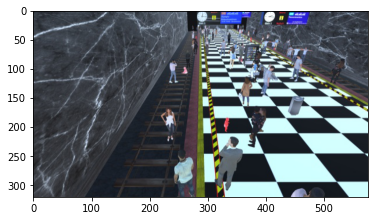

In [ ]:
#for single image
#create tensor
single_img_tensor = create_single_data('your input image path here')

#make prediction (to tensor size(1,5,w,h))
#output_tensor = model(single_img_tensor.to(device)) 

#make prediction (to rgb tensor size(1,3,w,h))
#output_rgb = create_rgb_output(single_img_tensor, model, device, dict_reverse)
plot_tensor(single_img_tensor[0])


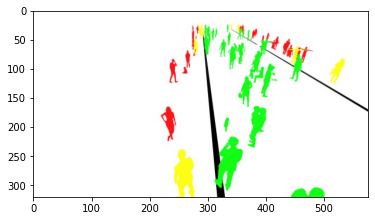

In [ ]:
#for single image
#create tensor
single_img_tensor = create_single_data('your target image path here')

#make prediction (to tensor size(1,5,w,h))
#output_tensor = model(single_img_tensor.to(device)) 

#make prediction (to rgb tensor size(1,3,w,h))
#output_rgb = create_rgb_output(single_img_tensor, model, device, dict_reverse)
plot_tensor(single_img_tensor[0])

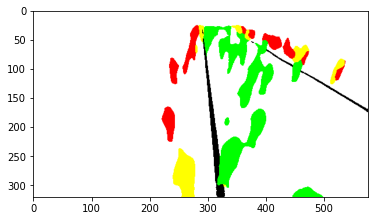

In [ ]:
#for single image
#create tensor
single_img_tensor = create_single_data('your input image path here')

#make prediction (to tensor size(1,5,w,h))
output_tensor = model(single_img_tensor.to(device)) 

#make prediction (to rgb tensor size(1,3,w,h))
output_rgb = create_rgb_output(single_img_tensor, model, device, dict_reverse)
plot_tensor(output_rgb[0])